# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Riemannian metrics

In this notebook, we solve Riemannian eikonal equations on the CPU and the GPU, and check that they produce consistent results.

**GPU performance** GPUs are massively parallel machines, which efficiently exploit cache locality. Hence they are at their advantage with :
* Large problem instances, which are embarassingly parallel
* Moderate anisotropy, so that the numerical scheme stncils are not too wide

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Isotropic metric](#1.1-Isotropic-metric)
    * [1.2 Smooth anisotropic metric](#1.2-Smooth-anisotropic-metric)
  * [2. Three dimensions](#2.-Three-dimensions)
    * [2.1 Smooth anisotropic metric](#2.1-Smooth-anisotropic-metric)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Riemann_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare
Eikonal.dictIn.default_mode = 'gpu'

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,RunGPU,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

### 0.1 Additional configuration

In [6]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 10. if strong_anisotropy else 4. # Ratio between the fastest and the smallest velocity at any given point

In [7]:
def surface_metric(x,z,mu):
    ndim,shape = x.ndim-1,x.shape[1:]
    x_ad = ad.Dense.identity(constant=x,shape_free=(ndim,))
    tensors = lp.outer_self( z(x_ad).gradient() ) + mu**-2 * fd.as_field(cp.eye(ndim),shape)
    return Metrics.Riemann(tensors)

## 1. Two dimensions

### 1.1 Isotropic metric

In [12]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'metric':Metrics.Riemann.from_cast(Metrics.Isotropic(cp.array(1.),vdim=2)),
    'seed':[0.5,0.5],
    'exportValues':1,
#    'bound_active_blocks':True,
    'traits':{
        'niter_i':24,'shape_i':(12,12), # Best
    }
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [10]:
_,cpuOut = RunCompare(hfmIn,check=1e-5)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.07550168037414551 seconds, and 86 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.787 s.
Solver time (s). GPU : 0.07550168037414551, CPU : 1.4500000000000002. Device acceleration : 19.20487057790746
Max |gpuValues-cpuValues| :  2.91457399725914e-06


In [11]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
cost = np.prod(np.sin(2*np.pi*X),axis=0)+1.1
hfmInS.update({
    'metric': Metrics.Riemann.from_cast(Metrics.Isotropic(cost,vdim=2)), # Isotropic but non-constant metric
    'verbosity':0,
})

In [11]:
RunCompare(hfmInS,variants='basic')

Solver time (s). GPU : 0.016005277633666992, CPU : 0.054. Device acceleration : 3.3738871162354203
Max |gpuValues-cpuValues| :  1.2913288426341651e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.016496658325195312, CPU : 0.051000000000000004. Device acceleration : 3.091535206382241
Max |gpuValues-cpuValues| :  4.5230663991979725e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.01599860191345215, CPU : 0.052. Device acceleration : 3.2502840111470426
Max |gpuValues-cpuValues| :  1.2437417652444438e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.016500473022460938, CPU : 0.051000000000000004. Device acceleration : 3.0908204831811354
Max |gpuValues-cpuValues| :  5.144490700104143e-08


In [12]:
RunCompare(hfmInS,variants='ext',check=0.004)

Solver time (s). GPU : 0.015001058578491211, CPU : 0.052. Device acceleration : 3.4664220346795083
Max |gpuValues-cpuValues| :  1.2913288426341651e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.012981891632080078, CPU : 0.054. Device acceleration : 4.159640330578513
Max |gpuValues-cpuValues| :  4.5230663991979725e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.015497922897338867, CPU : 0.051000000000000004. Device acceleration : 3.29076356475855
Max |gpuValues-cpuValues| :  1.2437417652444438e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.013988256454467773, CPU : 0.051000000000000004. Device acceleration : 3.645915426701437
Max |gpuValues-cpuValues| :  5.144490700104143e-08

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.015999794006347656, CPU : 0.054. Device acceleration : 3.375043452345473
Max |gpuValues-cpuValues| :  0.00014084236694447694

 -

### 1.2 Smooth anisotropic metric

In [58]:
n=3000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'seed':[0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':8,'shape_i':(8,8),},'fim_front_width':4, 
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)

In [7]:
def height(x): 
    r = fd.as_field(lp.rotation(cp.asarray(np.pi)/3),x.shape[1:])
    y = 2*lp.dot_AV(r,x)
    return np.sin(y[0])*np.sin(y[1]) 

In [60]:
hfmIn['metric'] = surface_metric(hfmIn.Grid(),height,mu=anisotropy_bound)

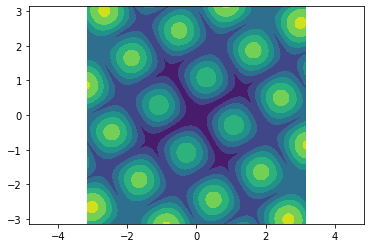

In [48]:
plt.contourf(*hfmIn.Grid(),hfmOut['values']) 
plt.axis('equal');

In [15]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.2395000457763672 seconds, and 254 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.429 s.
Solver time (s). GPU : 0.2395000457763672, CPU : 2.503. Device acceleration : 10.450937459682878
Max |gpuValues-cpuValues| :  5.266159390582281e-05


In [17]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
hfmInS.update({
    'metric' : surface_metric(hfmInS.Grid(),height,mu=anisotropy_bound), 
    'verbosity':0,
})

Casting output of function eye from float64 to float32


In [18]:
RunCompare(hfmInS,variants='basic')

Solver time (s). GPU : 0.030503034591674805, CPU : 0.088. Device acceleration : 2.8849588632082477
Max |gpuValues-cpuValues| :  7.824160913716405e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.043500423431396484, CPU : 0.091. Device acceleration : 2.091933659991011
Max |gpuValues-cpuValues| :  1.7039630373361092e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.03648114204406738, CPU : 0.091. Device acceleration : 2.494439452856947
Max |gpuValues-cpuValues| :  7.856240023862426e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.04350090026855469, CPU : 0.089. Device acceleration : 2.0459346691805145
Max |gpuValues-cpuValues| :  1.740857225041026e-07


Due to the different switching criteria of the second order scheme, we do not have bit consistency in that case. The results are nevertheless quite close. Note also that we do not deactivate the `decreasing` trait here, contrary to the isotropic case, because the scheme often does not converge without it.

**Bottom line.** Second order accuracy for anisotropic metrics on the GPU is very experimental, and not much reliable, at this stage. Further investigation is needed on the matter.

In [19]:
RunCompare(hfmInS,variants='ext',check=0.1)

Solver time (s). GPU : 0.0299990177154541, CPU : 0.093. Device acceleration : 3.100101506060004
Max |gpuValues-cpuValues| :  7.824160913716405e-06

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.04399871826171875, CPU : 0.091. Device acceleration : 2.068242066932547
Max |gpuValues-cpuValues| :  1.7039630373361092e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.03699779510498047, CPU : 0.091. Device acceleration : 2.4596060317051167
Max |gpuValues-cpuValues| :  7.856240023862426e-06

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.04350018501281738, CPU : 0.088. Device acceleration : 2.0229799016733074
Max |gpuValues-cpuValues| :  1.740857225041026e-07

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.036977291107177734, CPU : 0.092. Device acceleration : 2.4880135143848245
Max |gpuValues-cpuValues| :  0.0002934934470091993

 --- Variant {'factoringRadius': 10.0

If one removes enforced monotonicity, obtaining the scheme convergence is harder, and requires setting some other parameters carefully and conservatively.

<!---
hfmInS.update({
    'order2_threshold':0.03,
    'verbosity':1,
    'traits':{'decreasing_macro':0,'order2_threshold_weighted_macro':1},
    'metric' : surface_metric(hfmInS.Grid(),height),
    'multiprecision':False,
    'tol':1e-6
})
--->

In [20]:
hfmInS.update({
    'tol':1e-6, # Tolerance for the convergence of the fixed point solver
    'order2_threshold':0.03, # Use first order scheme if second order difference is too large
    'traits':{'decreasing_macro':0}, # Do not enforce monotonicity
})

In [21]:
RunCompare(hfmInS,variants='ext',check=0.15)

Solver time (s). GPU : 0.036493539810180664, CPU : 0.094. Device acceleration : 2.575798360173782
Max |gpuValues-cpuValues| :  1.1519648889790624e-05

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.040997982025146484, CPU : 0.088. Device acceleration : 2.1464471091778226
Max |gpuValues-cpuValues| :  1.99715544513257e-06

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.03650164604187012, CPU : 0.089. Device acceleration : 2.438246206702852
Max |gpuValues-cpuValues| :  1.1492123355161254e-05

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.033480167388916016, CPU : 0.088. Device acceleration : 2.628421745260849
Max |gpuValues-cpuValues| :  1.9622250657658213e-06

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.036997079849243164, CPU : 0.089. Device acceleration : 2.405595262184473
Max |gpuValues-cpuValues| :  0.0002934934470091993

 --- Variant {'factoringRadius': 1

In [ ]:
# TODO : discontinuous metric

## 2. Three dimensions

### 2.1 Smooth anisotropic metric

We generalize the two dimensional test case, although it does not much make geometrical sense anymore: we are computing geodesics in a three dimensional volume viewed as an hypersurface embedded in four dimensional Euclidean space.

In [20]:
n=200 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'Riemann3',
    'seed':[0.,0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':4},'fim_front_width':6,
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)

In [21]:
def height3(x): 
    r = fd.as_field(lp.rotation(cp.asarray(np.pi)/3,cp.asarray((1.,2,3))),x.shape[1:])
    y = 2*lp.dot_AV(r,x)
    return np.sin(y[0])*np.sin(y[1])*np.sin(y[2])

In [22]:
hfmIn['metric'] = surface_metric(hfmIn.Grid(),height3,mu=anisotropy_bound)

In [11]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-4)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define OffsetT_macro
typedef int OffsetT;
#define pruning_macro false
#define shape_i_macro
const int shape_i[3] = {4,4,4};
#define niter_i_macro
const int niter_i=5;
#define multiprecision_macro false
#define ndim_macro 3
#define fim_macro true
#define geom_indep_macro 0
#define import_scheme_macro false
#define local_i_macro true
#define periodic_macro false
#define isotropic_macro false
#define walls_macro false
const int size_i = 64;
const int log2_size_i = 6;
#include "Riemann_.h"
// Date cuda code last modified : 1602748496.237121

Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4805173873901367 seconds, and 142 iterations.
Post-Processing
--- gpu done, turning to cpu ---


KeyboardInterrupt: 

In [29]:
n=20; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[-np.pi,np.pi],[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
hfmInS.update({
    'metric' : surface_metric(hfmInS.Grid(),height,mu=anisotropy_bound), 
    'verbosity':0,
})

Casting output of function eye from float64 to float32


In [30]:
RunCompare(hfmInS,variants='basic')

Solver time (s). GPU : 0.008499622344970703, CPU : 0.038000000000000006. Device acceleration : 4.470786872370267
Max |gpuValues-cpuValues| :  2.67317871505135e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.008997201919555664, CPU : 0.038. Device acceleration : 4.223535310173039
Max |gpuValues-cpuValues| :  4.1609422674060426e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.006497621536254883, CPU : 0.036000000000000004. Device acceleration : 5.540488900304554
Max |gpuValues-cpuValues| :  2.0110513232474148e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.009000062942504883, CPU : 0.035. Device acceleration : 3.8888616917004426
Max |gpuValues-cpuValues| :  4.477440634920171e-07


Due to the different switching criteria of the second order scheme, we do not have bit consistency in that case. The results are nevertheless quite close.

In [31]:
RunCompare(hfmInS,variants='ext',check=0.1)

Solver time (s). GPU : 0.009010076522827148, CPU : 0.038. Device acceleration : 4.217500251382604
Max |gpuValues-cpuValues| :  2.67317871505135e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.0089874267578125, CPU : 0.037000000000000005. Device acceleration : 4.116862478777589
Max |gpuValues-cpuValues| :  4.1609422674060426e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.0069980621337890625, CPU : 0.037000000000000005. Device acceleration : 5.287177977650587
Max |gpuValues-cpuValues| :  2.0110513232474148e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.00799870491027832, CPU : 0.037000000000000005. Device acceleration : 4.6257488449730255
Max |gpuValues-cpuValues| :  4.477440634920171e-07

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.007008075714111328, CPU : 0.045. Device acceleration : 6.421163502755665
Max |gpuValues-cpuValues| :  0.014765998189